<a href="https://colab.research.google.com/github/CodeByGui-hub/student-projects/blob/main/deteccao_cancer_mama/deteccao_inbreast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introdução e Referências**
# Projeto de Detecção de Lesões Mamárias usando Deep Learning

Este notebook utiliza a base de dados **INbreast** (Full-Field Digital Mammography Dataset) para treinar um modelo de classificação de lesões mamárias.  
A base INbreast contém imagens de mamografias em alta resolução com anotações detalhadas de regiões de interesse (ROIs), incluindo calcificações e massas.

**Referências:**
- Moreira, I. C., et al. (2012). *INbreast: Toward a full-field digital mammographic database*. Academic Radiology, 19(2), 236–248.  
- Dataset INbreast: [https://www.inbreast.com/](https://www.inbreast.com/)  
- Frameworks utilizados: Python 3, PyTorch, Albumentations, OpenCV, NumPy, Matplotlib, Scikit-learn.

Este notebook realiza os seguintes passos principais:
1. Pré-processamento das imagens e anotações XML.
2. Criação de máscaras e extração de patches das ROIs.
3. Divisão dos dados em treino, validação e teste.
4. Treinamento de modelo DenseNet121 pré-treinado para classificação binária (calcificação vs. massa).
5. Avaliação do modelo e visualização da matriz de confusão.

# **Importação de Bibliotecas e Dependências**

Este bloco reúne todas as bibliotecas utilizadas ao longo do projeto, abrangendo desde manipulação de dados e imagens até treinamento e avaliação do modelo de Deep Learning.

In [1]:
import gc
import PIL
import numpy as np
import cv2
import glob
import random
import shutil
import os
import seaborn as sns
import torch
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import plistlib
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from pathlib import Path
from torch import optim
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
from IPython.display import clear_output
from google.colab import files
from skimage.draw import polygon
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:
files.upload()                      # Faz o upload manual de arquivos no ambiente do Google Colab
!unzip "INbreast Release 1.0.zip"   # Descompacta o dataset INbreast no diretório atual
clear_output()                      # Limpa a saída da célula para manter o notebook organizado

# **Definição de Diretórios e IDs de Pacientes**

Define caminhos para imagens e anotações XML, além de extrair os IDs de pacientes.

In [3]:
# Diretórios contendo as imagens em PNG e os arquivos de anotação em XML
png_path = '/content/INbreast Release 1.0/INbreast Release 1.0/ALLPNG'
xml_path = '/content/INbreast Release 1.0/INbreast Release 1.0/AllXML'

# Lista de IDs dos pacientes extraída a partir dos nomes dos arquivos XML
patient_id = [p.replace('.xml', '') for p in os.listdir(xml_path)]

# **Classes Auxiliares para Imagens e Anotações**
Define as classes `ImageFormat`, `XMLAnnotation` e `ROI` para manipulação de imagens, leitura de XMLs e criação de máscaras das ROIs.

In [4]:
class ImageFormat():
    def __init__(self, png_path):
        # Caminho para um arquivo PNG específico ou para um diretório contendo imagens
        self.png_path = png_path

    def resize_images(self, target_size=(300, 300)):
        # Redimensiona uma imagem única ou todas as imagens PNG de um diretório
        if os.path.isfile(self.png_path):  # arquivo único
            image = Image.open(self.png_path)
            resized_image = image.resize(target_size)
            resized_image.save(self.png_path)
        else:  # pasta
            for f in glob.glob(self.png_path + '/*.png'):
                image = Image.open(f)
                resized_image = image.resize(target_size)
                resized_image.save(f)
        print(f"Redimensionamento concluído para {self.png_path} com tamanho {target_size}.")

    def array_pixels(self):
        # Converte uma imagem ou um conjunto de imagens em arrays NumPy
        all_image_arrays = []

        if os.path.isfile(self.png_path):  # arquivo único
            img = Image.open(self.png_path)
            all_image_arrays.append(np.array(img))
        else:  # pasta
            for f in glob.glob(self.png_path + '/*.png'):
                img = Image.open(f)
                all_image_arrays.append(np.array(img))

        return all_image_arrays

    def dimension_images(self):
        # Obtém as dimensões (largura, altura) das imagens
        all_image_dimension = []

        if os.path.isfile(self.png_path):
            img = Image.open(self.png_path)
            all_image_dimension.append(img.size)
        else:
            for f in glob.glob(self.png_path + '/*.png'):
                img = Image.open(f)
                all_image_dimension.append(img.size)

        return all_image_dimension

In [5]:
class XMLAnnotation():
    # Classe para manipular e extrair anotações de arquivos XML (plist) do dataset
    def __init__(self, xml_path, patient_ids_keys):
        # Recebe o caminho da pasta com os XMLs e a lista de IDs de pacientes
        self.xml_path = xml_path
        self.patient_ids_keys = patient_ids_keys

    def point(self, point_px_str):
        # Converte uma string de ponto "(x, y)" em tupla de floats (x, y)
        x_str, y_str = point_px_str.strip('()').split(',')
        return float(x_str.strip()), float(y_str.strip())

    def get_xml_annotation(self):
        # Retorna todas as anotações extraídas dos XMLs em um dicionário estruturado
        all_annotations = {}

        for patient_id_key in self.patient_ids_keys:
            file = os.path.join(self.xml_path, patient_id_key + '.xml')
            try:
                with open(file, 'rb') as f:
                    xml_load = plistlib.load(f)

                    if patient_id_key not in all_annotations:
                        all_annotations[patient_id_key] = {}

                    # Percorre todas as imagens do XML
                    for image in xml_load.get('Images', []):
                        image_uid = str(image.get('ImageIndex', 0))
                        image_rois = []

                        # Percorre todos os ROIs da imagem
                        for roi in image.get('ROIs', []):
                            name = roi.get('Name')
                            num_points = roi.get('NumberOfPoints')
                            index_in_image = roi.get('IndexInImage', None)
                            point_px_list = roi.get('Point_px', [])

                            # Converte todos os pontos em tuplas de floats
                            points_px = [self.point(px_str) for px_str in point_px_list]

                            roi_dict = {
                                'Name': name,
                                'NumberOfPoints': num_points,
                                'IndexInImage': index_in_image,
                                'Point_px': points_px
                            }
                            image_rois.append(roi_dict)

                        all_annotations[patient_id_key][image_uid] = image_rois

            except FileNotFoundError:
                print(f"XML não encontrado para o patient_id {patient_id_key}.")
            except Exception as e:
                print(f'Erro ao processar {file}: {e}')

        return all_annotations

In [6]:
class ROI():
    # Representa uma região de interesse (ROI) em uma imagem, incluindo tipo de lesão, vértices e máscara
    def __init__(self, lesion_type, vertices, imshape, index_in_image=None):
    # Representa uma região de interesse (ROI) em uma imagem, incluindo tipo de lesão, vértices e máscara
        self.lesion_type = lesion_type
        self.vertices = vertices
        self.index_in_image = index_in_image
        self.imshape = imshape

    def is_point(self):
        # Verifica se a ROI é apenas um ponto único
        return len(self.vertices) == 1

    def calculate_bbox(self):
        # Calcula o bounding box da ROI
        if self.is_point():
            x, y = self.vertices[0]
            eps = 2  # extensão mínima para pontos únicos & pode ajustar depois
            return (int(x), int(y), int(x + eps), int(y + eps))

        x_coords = [v[0] for v in self.vertices]
        y_coords = [v[1] for v in self.vertices]

        x_min = min(x_coords)
        x_max = max(x_coords)
        y_min = min(y_coords)
        y_max = max(y_coords)

        return (int(x_min), int(y_min), int(x_max), int(y_max))

    def mask(self):
        # Gera uma máscara binária da ROI (1 na região, 0 fora)
        mask = np.zeros(self.imshape, dtype=np.uint8)
        height, width = self.imshape

        if self.is_point():
            x, y = self.vertices[0]
            x = max(0, min(int(x), width - 1))
            y = max(0, min(int(y), height - 1))
            mask[y, x] = 1
            return mask

        # Para ROI poligonal, preenche a área do polígono
        rr, cc = polygon([v[1] for v in self.vertices], [v[0] for v in self.vertices], shape=self.imshape)
        if len(rr) == 0 or len(cc) == 0:
            return mask

        mask[rr, cc] = 1
        return mask

# **Processamento das Anotações XML e Organização de Imagens**
Processa os XMLs e cria um mapeamento paciente -> imagens PNG, preparando para criar o dataset.


In [7]:
xml_parser = XMLAnnotation(xml_path=xml_path, patient_ids_keys=patient_id) # Cria o objeto para processar os XMLs de anotações
annotations_data = xml_parser.get_xml_annotation() # Extrai todas as anotações e armazena em um dicionário estruturado

In [8]:
# Cria um mapeamento entre cada paciente e suas imagens PNG
patient_image_map = {}

# Percorre todas as imagens PNG e organiza por patient_id
for f in glob.glob(os.path.join(png_path, '*.png')):
  p_id = os.path.basename(f).split('_')[0]
  if p_id not in patient_image_map:
    patient_image_map[p_id] = []
  patient_image_map[p_id].append(f)

# Ordena as imagens de cada paciente para manter sequência consistente
for p_id in patient_image_map:
    patient_image_map[p_id] = sorted(patient_image_map[p_id])

In [9]:
# Itera sobre todas as anotações de todos os pacientes e imprime cada ROI
for i in patient_id:
  for j in annotations_data[i]:
    for k in annotations_data[i][j]:
      print(k)

# Limpa a saída da célula para manter o notebook organizado
clear_output()

# **Criação do Dataset com Imagens, ROIs e Máscaras**
Itera sobre pacientes e imagens, cria objetos de imagem, extrai ROIs, gera máscaras binárias e armazena tudo no dicionário `dataset`.

In [10]:
# Inicializa um dicionário vazio que vai armazenar o dataset completo
dataset = {}

# Itera por cada paciente na lista patient_id
for i in patient_id:
    # Verifica se o paciente possui imagens correspondentes
    if i not in patient_image_map or len(patient_image_map[i]) == 0:
        print(f"Atenção: paciente {i} não tem imagens correspondentes.")
        continue

    # Ordena a lista de imagens do paciente
    png_list = sorted(patient_image_map[i])
    # Obtém as anotações (ROIs) do paciente
    rois_image = annotations_data[i]
    # Inicializa o dicionário do paciente dentro do dataset
    dataset[i] = {}

    # Itera por cada imagem do paciente
    for j, png_archive_path in enumerate(png_list):
        # Carrega a imagem como objeto (não carrega o array completo ainda)
        image_obj = ImageFormat(png_archive_path)
        # Cria array da imagem apenas para gerar máscaras
        image_array = image_obj.array_pixels()[0]

        # Obtém as ROIs da imagem (se houver)
        rois_xml = rois_image.get('0', [])
        if not rois_xml:
            print(f"Atenção: paciente {i}, imagem {j} não tem ROIs")
            continue

        roi_objects = [] # Lista para armazenar objetos ROI da imagem
        # Cria máscara composta inicializada com zeros (mesmo tamanho da imagem)
        composite_mask = np.zeros(image_array.shape, dtype=np.uint8)

        # Itera por cada ROI da imagem
        for k in rois_xml:
            lesion_type = k['Name']
            vertices = k['Point_px']
            index_in_image = k.get('IndexInImage', None)

            # Cria objeto ROI
            roi_obj = ROI(
                lesion_type=lesion_type,
                vertices=vertices,
                imshape=image_array.shape,
                index_in_image=index_in_image
            )
            roi_objects.append(roi_obj)

            # Atualiza máscara composta combinando com a máscara da ROI
            composite_mask |= roi_obj.mask().astype(np.uint8)

        # Armazena no dataset apenas referência à imagem, lista de ROIs e máscara
        dataset[i][j] = {
            'image': image_obj,      # objeto da imagem
            'rois': roi_objects,     # lista de objetos ROI
            'mask': composite_mask   # máscara binária composta
        }

        # Remove arrays temporários para liberar memória
        del image_array, composite_mask

# **Visualização de Imagens, ROIs e Máscaras das ROIs**
Exibe um número limitado de imagens originais, imagens com bounding boxes das ROIs e as máscaras binárias das ROIs.


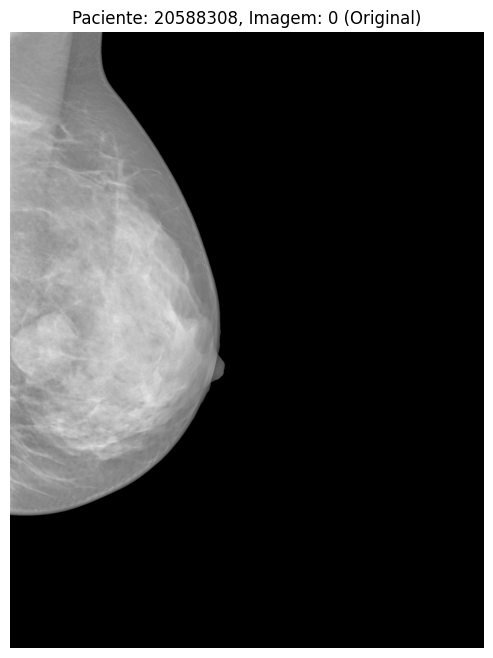

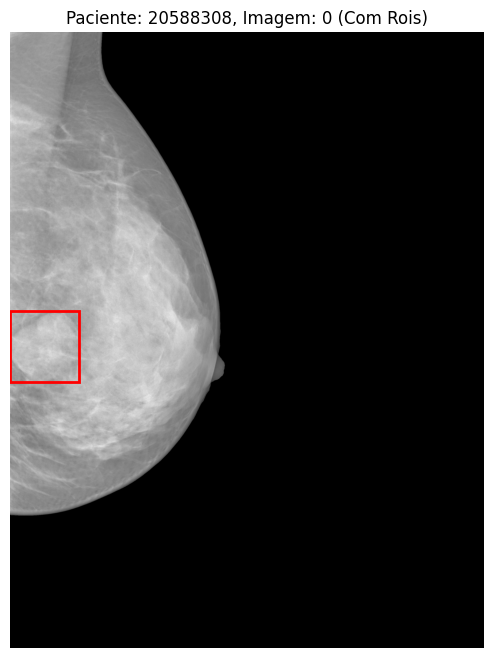

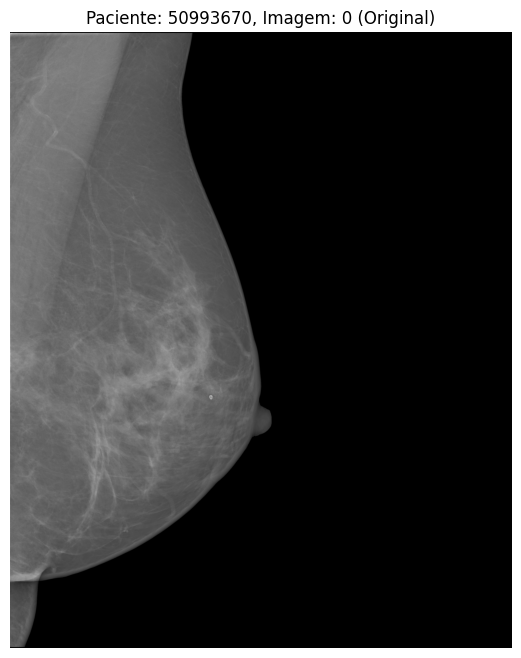

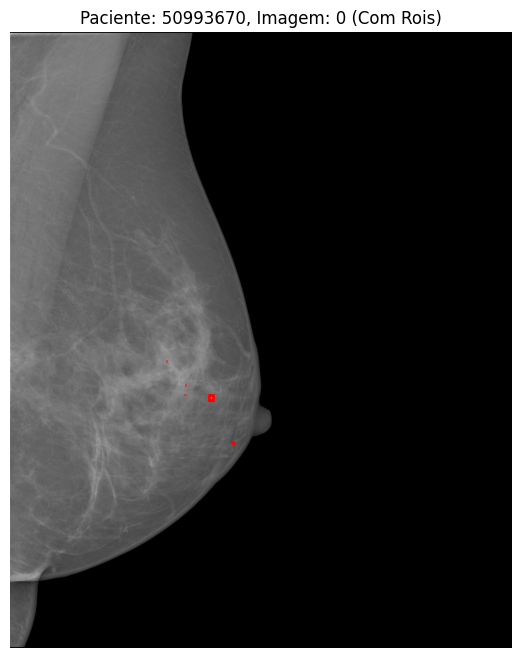

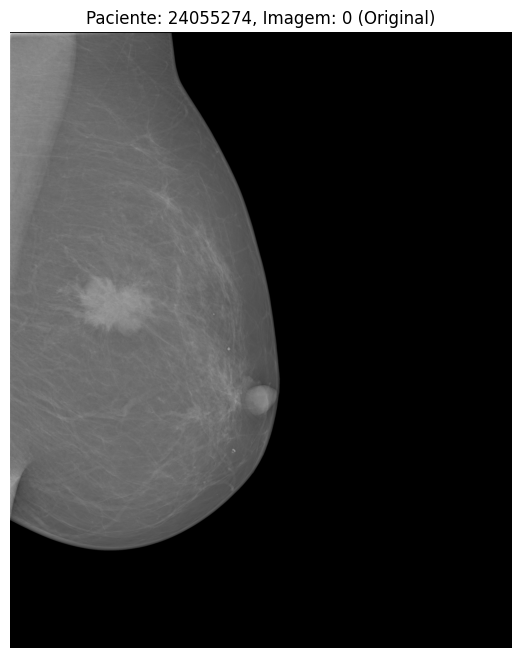

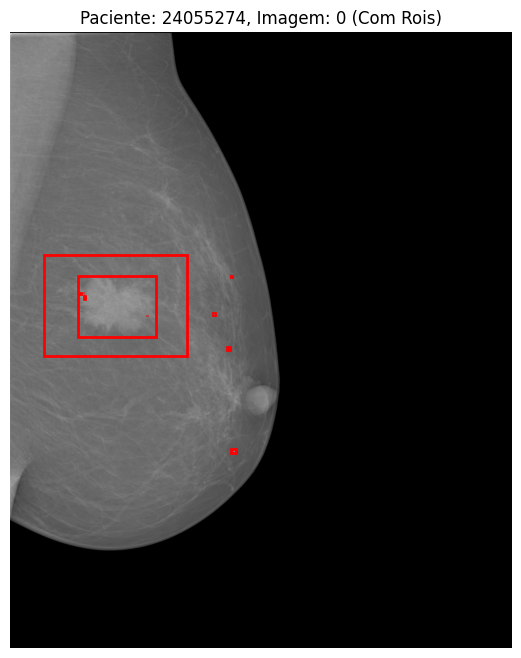

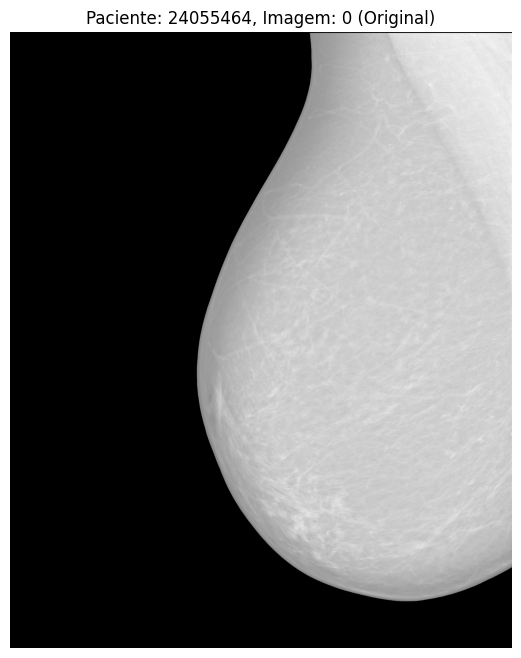

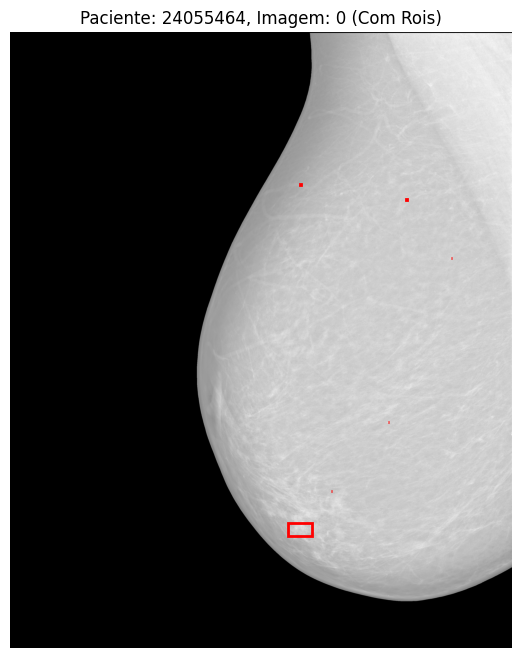

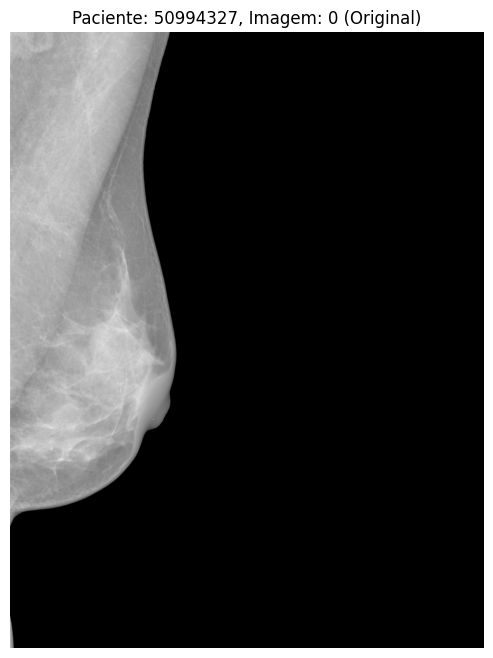

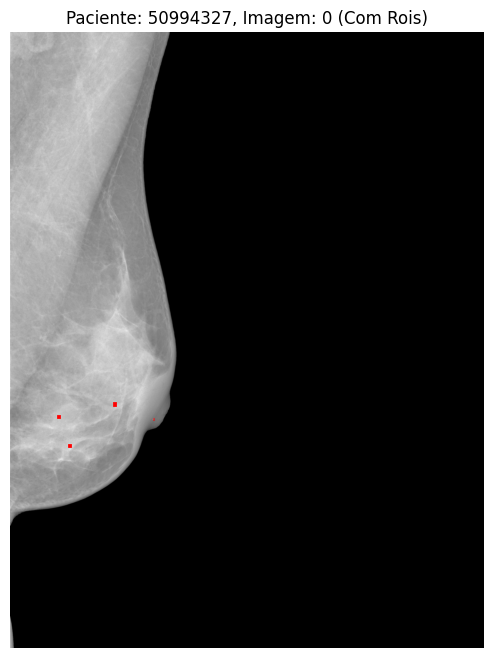

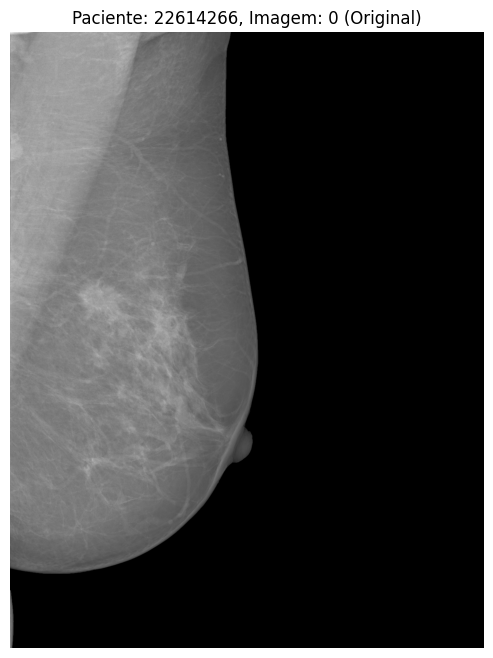

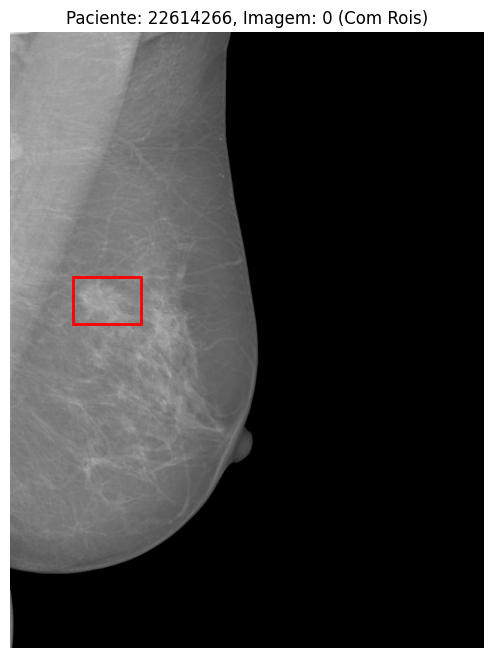

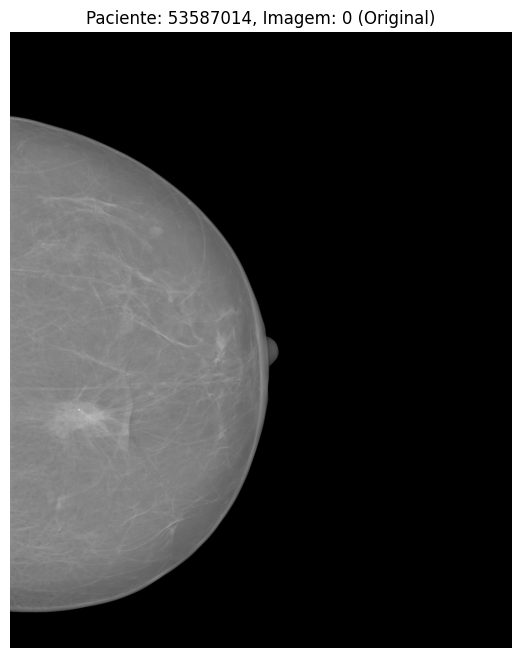

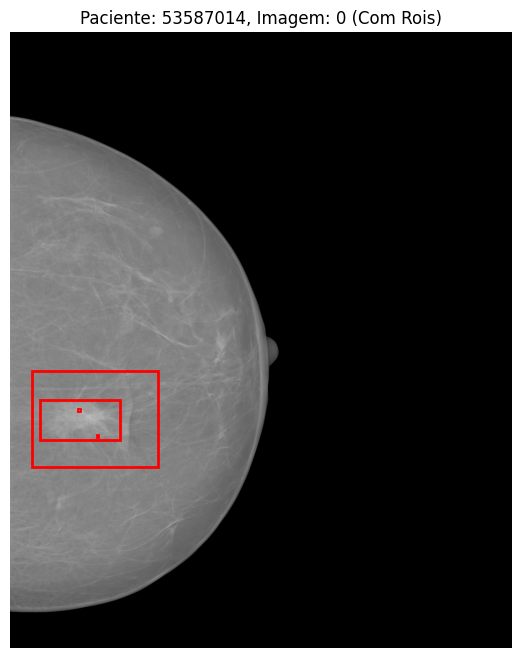

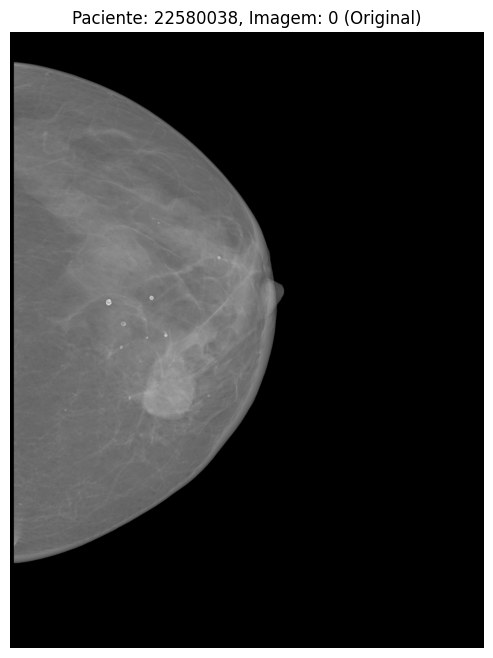

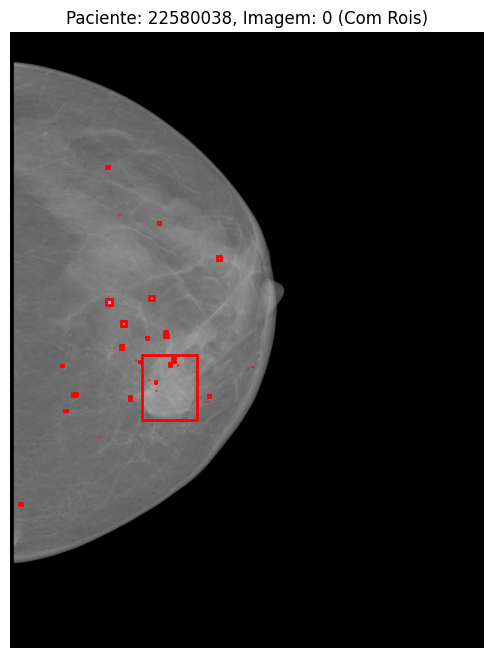

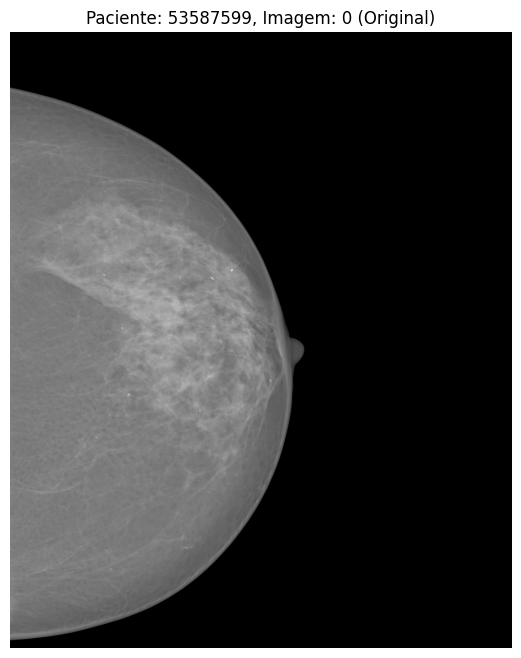

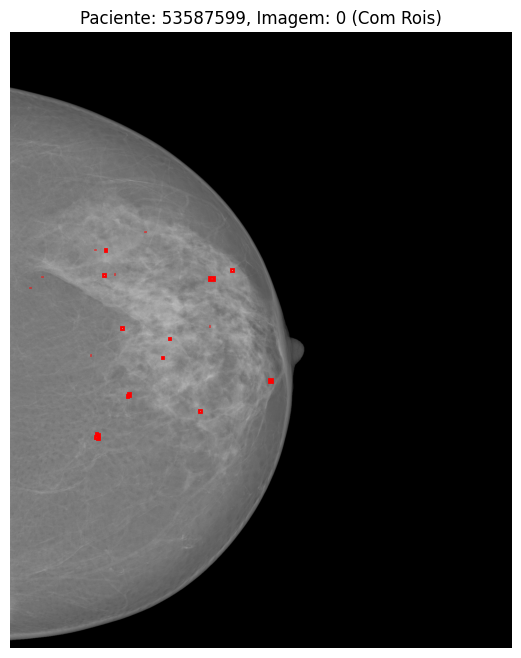

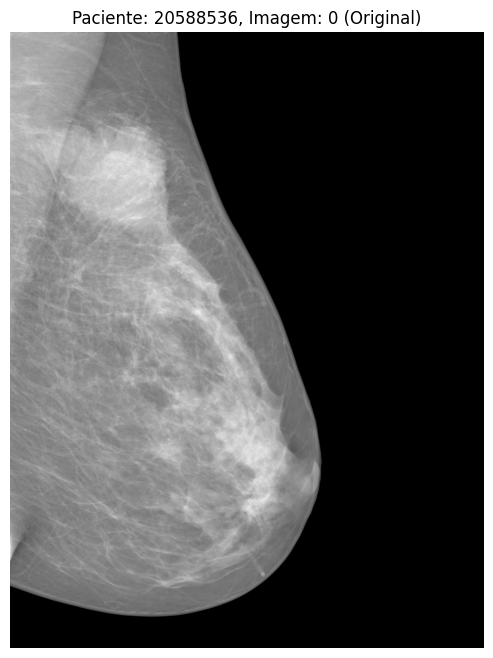

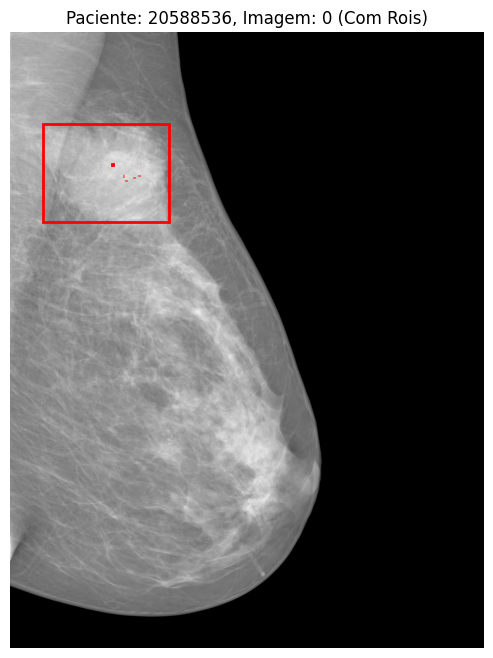

In [11]:
limite_total = 10   # Limita o número total de imagens exibidas
total_exibidas = 0  # Contador para controlar quantas imagens já foram exibidas

# Percorre o dataset e exibe imagens originais e com ROIs sobrepostas
for i in dataset:
    for j in dataset[i]:
        if total_exibidas >= limite_total:
            break
        # Recupera o objeto da imagem e a lista de ROIs da imagem atual
        img_obj = dataset[i][j]['image']
        rois = dataset[i][j]['rois']

        # Garante que o array da imagem esteja carregado no objeto
        # Se ainda não existir o atributo 'array', carrega os pixels
        if not hasattr(img_obj, 'array'):
            image_array = img_obj.array_pixels()[0]
            img_obj.array = image_array
        else:
            # Se já estiver carregado, apenas usa o array existente
            image_array = img_obj.array

        # Exibe a imagem original
        plt.figure(figsize=(8, 8))
        plt.imshow(image_array, cmap='gray')
        plt.title(f'Paciente: {i}, Imagem: {j} (Original)')
        plt.axis('off')
        plt.show()

        # Exibe a imagem com os bounding boxes das ROIs
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(image_array, cmap='gray')

        # Para cada ROI da imagem, desenha o bounding box
        for roi in rois:
            x_min, y_min, x_max, y_max = roi.calculate_bbox()
            # Cria o retângulo usando as coordenadas da ROI
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            # Adiciona o retângulo ao eixo da imagem
            ax.add_patch(rect)

        plt.title(f'Paciente: {i}, Imagem: {j} (Com Rois)')
        plt.axis('off')
        plt.show()

        # Incrementa o contador de imagens exibidas
        total_exibidas += 1

    # Verifica novamente se atingiu o limite total após terminar o paciente
    if total_exibidas >= limite_total:
        break

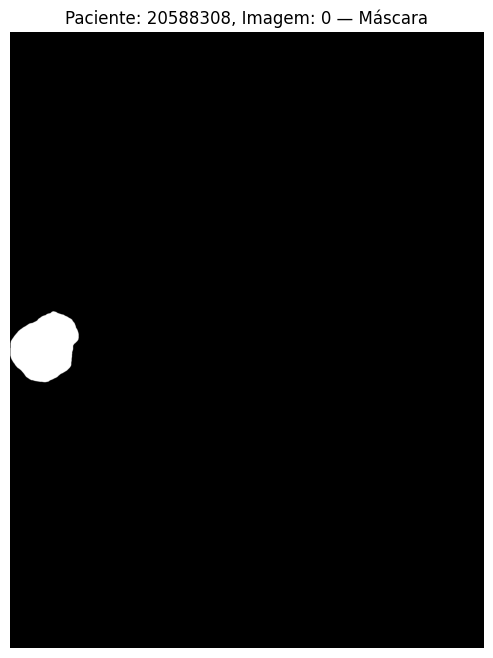

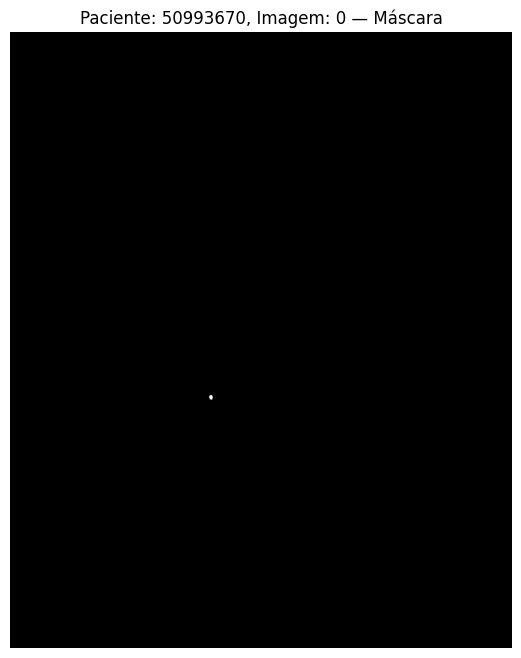

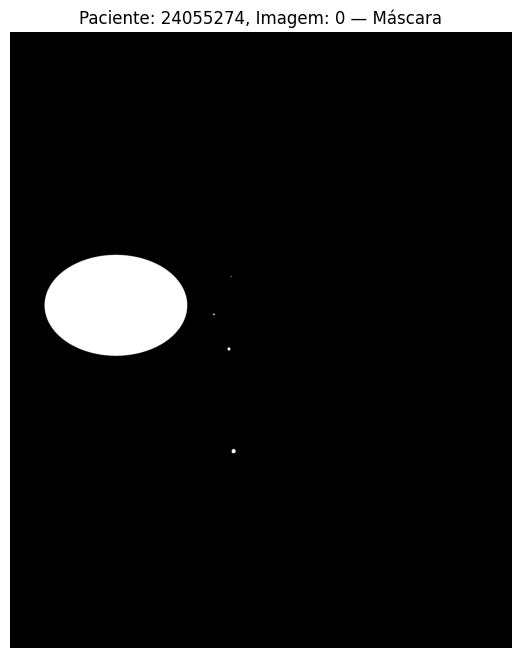

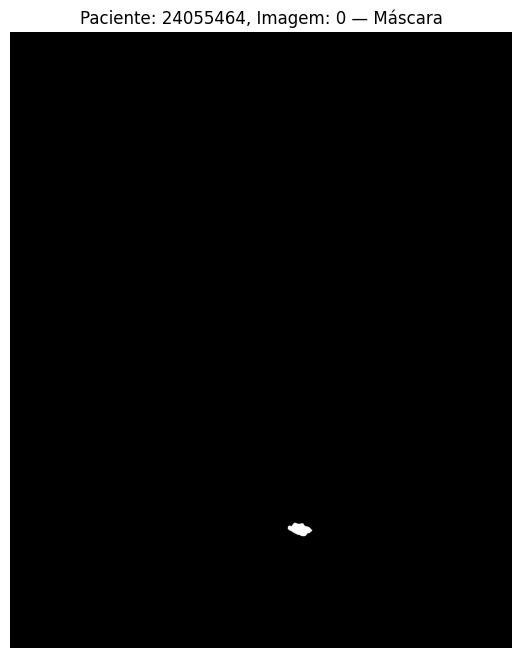

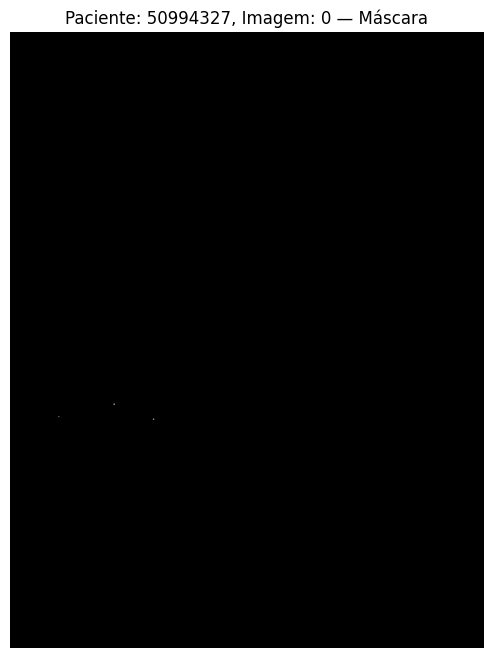

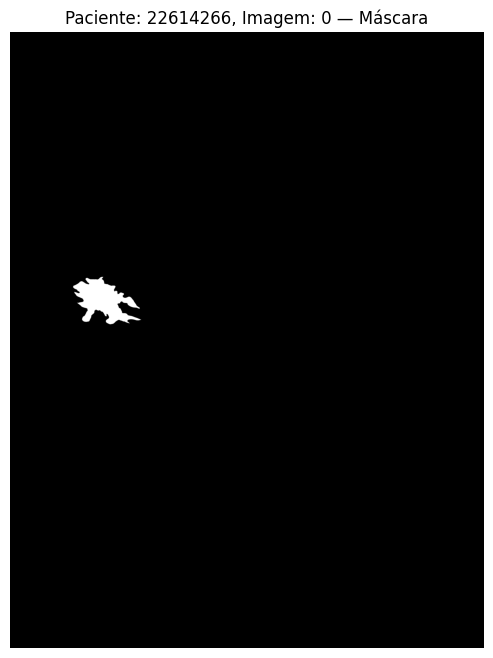

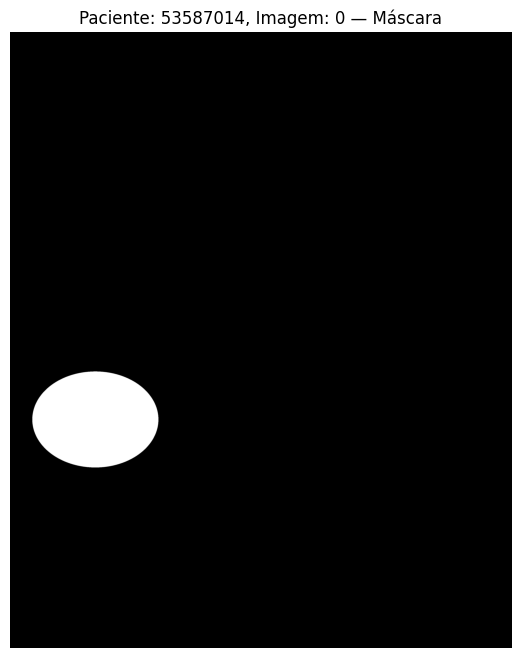

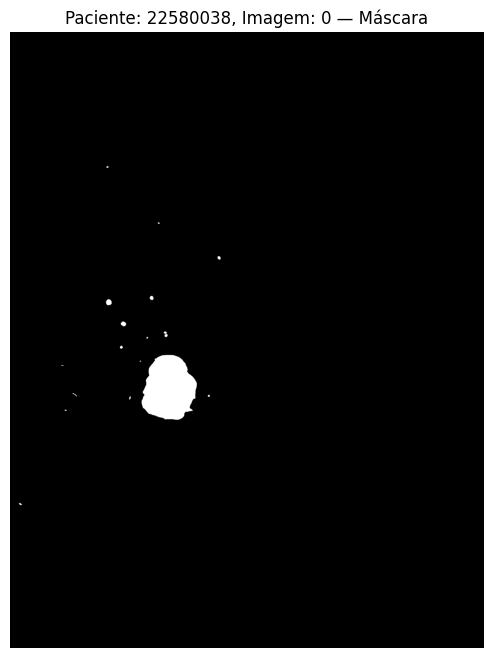

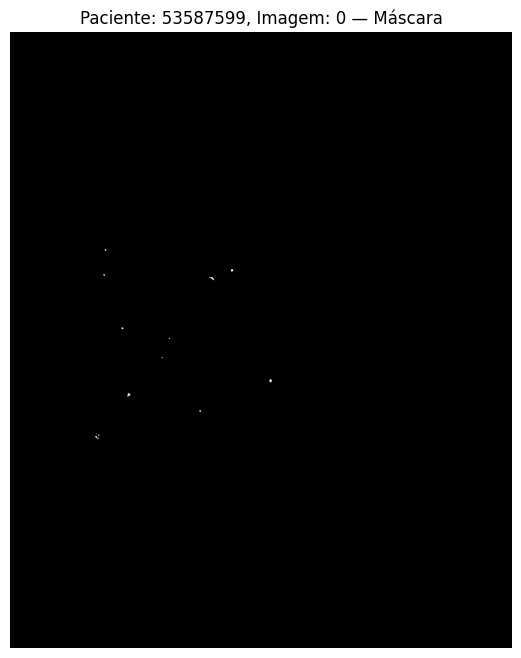

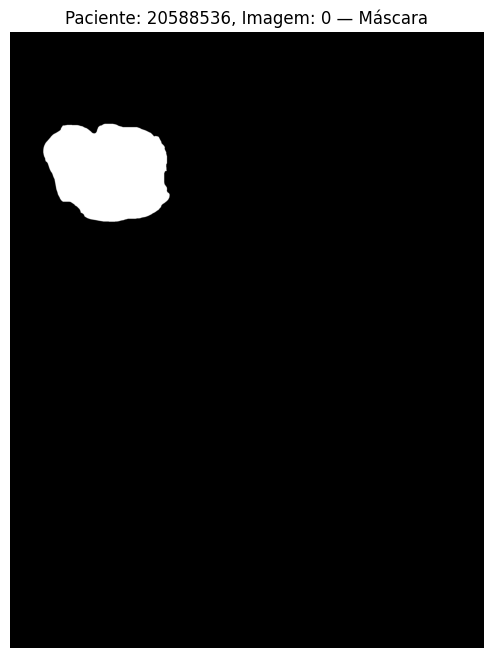

In [12]:
limite_total = 10   # Define o número máximo de máscaras que serão exibidas
total_exibidas = 0  # Contador para controlar quantas máscaras já foram exibidas

# Percorre o dataset e exibe imagens originais e com ROIs sobrepostas
for i in dataset:
    for j in dataset[i]:
        if total_exibidas >= limite_total:
            break

        # Recupera a máscara da imagem
        mask = dataset[i][j]['mask']
        # Se não houver máscara, pula para a próxima imagem
        if mask is None:
            continue

        # Exibição da máscara
        plt.figure(figsize=(8, 8))
        plt.imshow(mask, cmap='gray')
        plt.title(f'Paciente: {i}, Imagem: {j} — Máscara')
        plt.axis('off')
        plt.show()

        # Fecha a figura para liberar memória
        plt.close()
        # Executa coleta de lixo para liberar memória de arrays grandes
        gc.collect()

        # Incrementa o contador de máscaras exibidas
        total_exibidas += 1

    # Verifica novamente se atingiu o limite total após terminar o paciente
    if total_exibidas >= limite_total:
        break

# **Extração de Patches e Rótulos das ROIs**
Extrai patches das imagens com base nas ROIs e armazena junto com os rótulos (calcificação = 0, massa = 1 (caso tenha)) para cada paciente.

In [13]:
# Extrai patches das ROIs para cada paciente, armazenando os patches e seus rótulos
patient_patches = {}

for patient_key, image_data in dataset.items():
    cropped_patches = []
    cropped_labels = []

    for image_idx, image_info in image_data.items():
        img_object = image_info['image']
        rois_list = image_info['rois']

        # Garante que o array da imagem esteja carregado
        if not hasattr(img_object, 'array'):
            image_array = img_object.array_pixels()[0]
            img_object.array = image_array
        else:
            image_array = img_object.array

        # Ignora imagens sem ROIs
        if not rois_list:
            print(f"DEBUG: Paciente {patient_key}, Image {image_idx} rois_list vazia. Ignorando extração de Patch.")
            continue

        # Extrai cada patch com base no bounding box da ROI
        for roi in rois_list:
            x_min, y_min, x_max, y_max = roi.calculate_bbox()

            print(f"DEBUG: Paciente {patient_key}, Image {image_idx}, ROI type: {roi.lesion_type}, BBox: ({x_min}, {y_min}, {x_max}, {y_max})")

            # Garante que as coordenadas do patch estejam dentro dos limites da imagem
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(image_array.shape[1], x_max)
            y_max = min(image_array.shape[0], y_max)

            patches = image_array[y_min:y_max, x_min:x_max]

            # Armazena patch e rótulo se válido
            if patches.shape[0] > 0 and patches.shape[1] > 0:
                print(f"DEBUG: Paciente {patient_key}, Image {image_idx}, ROI type: {roi.lesion_type}, Patch shape: {patches.shape}")
                cropped_patches.append(patches)
                cropped_labels.append(0 if roi.lesion_type == 'calcification' else 1)
            else:
                print(f"DEBUG: Paciente {patient_key}, Image {image_idx}, ROI type: {roi.lesion_type}, Extração de Patch vazia ou inválida. Shape: {patches.shape}")

    # Salva todos os patches e labels do paciente
    patient_patches[patient_key] = (cropped_patches, cropped_labels)

# Limpa a saída da célula para manter o notebook organizado
clear_output()

In [14]:
# Cria uma lista com os IDs de todos os pacientes que têm patches extraídos
patients = list(patient_patches.keys())

# **Divisão de Dados em Treino, Validação e Teste**
Divide os pacientes em conjuntos de treino (70%), validação (15%) e teste (15%) para criar DataLoaders posteriormente.

In [15]:
# Divide os pacientes em conjuntos de treino, validação e teste
# 70% treino, 15% validação e 15% teste
train_patients, temp_patients = train_test_split(patients, test_size=0.3, random_state=55)
val_patients, test_patients = train_test_split(temp_patients, test_size=0.5, random_state=55)

In [16]:
# Define o dispositivo de execução: GPU se disponível, caso contrário CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# **Transformações e Dataset Personalizado**
Define transformações com Albumentations para treino e validação e cria a classe `INbreast_Dataset` para carregar patches.

In [17]:
# Define as transformações para as imagens de treino
# Inclui redimensionamento, flips aleatórios, ajuste de brilho/contraste, rotação e normalização
train_transform = A.Compose([
    A.Resize(300, 300, interpolation=cv2.INTER_CUBIC),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(scale_limit=0, rotate_limit=180, border_mode=0),
    A.Lambda(image=lambda x, **kwargs: np.repeat(x, 3, axis=2)),  # converte 1 canal -> 3 canais
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Define as transformações para as imagens de validação
# Apenas redimensionamento, conversão para 3 canais e normalização
val_transform = A.Compose([
    A.Resize(300, 300, interpolation=cv2.INTER_CUBIC),
    A.Lambda(image=lambda x, **kwargs: np.repeat(x, 3, axis=2)), # converte 1 canal -> 3 canais
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1936771235.py:9: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: np.repeat(x, 3, axis=2)),  # converte 1 canal -> 3 canais
/tmp/ipython-input-1936771235.py:18: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: np.repeat(x, 3, axis=2)), # converte 1 canal -> 3 canais


In [18]:
# Função para combinar patches e rótulos de múltiplos pacientes em listas únicas
def combine_patients(patient_list):
    X, y = [], []

    for p in patient_list:
        patches, labels = patient_patches[p]
        X.extend(patches)
        y.extend(labels)

    return X, y

# Combina os patches e rótulos de treino, validação e teste
train_patches, train_labels = combine_patients(train_patients)
val_patches, val_labels = combine_patients(val_patients)
test_patches, test_labels = combine_patients(test_patients)

In [19]:
class INbreast_Dataset(Dataset):
    # Dataset customizado para os patches do INbreast
    # Suporta transformações opcionais com Albumentations

    def __init__(self, patches, labels, transform=None):
        # Inicializa o dataset com patches, rótulos e transformações opcionais
        self.patches = patches
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # Retorna o número total de patches no dataset
        return len(self.patches)

    def __getitem__(self, idx):
        # Retorna um patch e seu rótulo correspondente
        patch = self.patches[idx]
        label = self.labels[idx]

        # Normaliza os valores dos pixels entre 0 e 1
        patch = patch.astype(np.float32) / 255.0

        # Adiciona canal extra para compatibilidade com transformações
        patch = np.expand_dims(patch, axis=2)  # (H, W, 1)

        # Aplica transformações se fornecidas
        if self.transform:
            augmented = self.transform(image=patch)
            patch = augmented['image']

        return patch, label

# **Criação de DataLoaders**
Cria DataLoaders de treino, validação e teste com o batch size definido.

In [20]:
# Define o tamanho do batch para os DataLoaders
batch_size = 50

# Cria dataset e dataloader de treino com embaralhamento
train_dataset = INbreast_Dataset(train_patches, train_labels, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Cria dataset e dataloader de validação (sem embaralhamento)
val_dataset = INbreast_Dataset(val_patches, val_labels, transform=train_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Cria dataset e dataloader de teste (sem embaralhamento)
test_dataset = INbreast_Dataset(test_patches, test_labels, transform=train_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Criação e Configuração do Modelo DenseNet121**
Carrega DenseNet121 pré-treinado, altera a camada final para 2 classes e define dispositivo, otimizador e função de perda.

In [21]:
# Carrega o modelo DenseNet121 pré-treinado
model = models.densenet121(pretrained=True)

# Substitui a camada final para classificação binária (2 classes)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

# Move o modelo para o dispositivo disponível (CPU ou GPU)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# Define a taxa de aprendizado
lr = 0.001

# Função de perda para classificação binária
criterion = nn.CrossEntropyLoss()

# Otimizador Adam apenas para os parâmetros da camada final
optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

# **Treinamento do Modelo**
Loop de treinamento por época, incluindo cálculo de métricas de treino e validação.

In [23]:
# Número de épocas para treino
num_epochs = 5

# Loop de treino
for epoch in range(num_epochs):
    model.train() # define o modelo no modo treino
    running_loss = 0
    all_preds = []
    all_labels = []

    # Itera sobre os batches de treino
    for patches, labels in train_dataloader:
        patches, labels = patches.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(patches)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * patches.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calcula métricas de treino
    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds)

    # Validação
    model.eval() # define o modelo no modo avaliação
    val_preds = []
    val_labels_list = []
    val_loss = 0

    with torch.no_grad():
        for patches, labels in val_dataloader:
            patches, labels = patches.to(device), labels.to(device)
            outputs = model(patches)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * patches.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    # Calcula métricas de validação
    val_acc = accuracy_score(val_labels_list, val_preds)
    val_f1 = f1_score(val_labels_list, val_preds)
    val_loss /= len(val_dataset)
    train_loss = running_loss / len(train_dataset)

    # Exibe métricas por época
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

# =========================
# 7️⃣ Avaliação final no teste
# =========================
model.eval()
test_preds = []
test_labels_list = []

with torch.no_grad():
    for patches, labels in test_dataloader:
        patches, labels = patches.to(device), labels.to(device)
        outputs = model(patches)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

# Calcula métricas finais no conjunto de teste
test_acc = accuracy_score(test_labels_list, test_preds)
test_f1 = f1_score(test_labels_list, test_preds)

print(f"Test Accuracy: {test_acc:.4f}, Test F1-score: {test_f1:.4f}")

Epoch 1/5 | Train Loss: 0.0133, Acc: 0.9983, F1: 0.9991 | Val Loss: 0.0001, Acc: 1.0000, F1: 1.0000
Epoch 2/5 | Train Loss: 0.0002, Acc: 1.0000, F1: 1.0000 | Val Loss: 0.0001, Acc: 1.0000, F1: 1.0000
Epoch 3/5 | Train Loss: 0.0001, Acc: 1.0000, F1: 1.0000 | Val Loss: 0.0001, Acc: 1.0000, F1: 1.0000
Epoch 4/5 | Train Loss: 0.0001, Acc: 1.0000, F1: 1.0000 | Val Loss: 0.0001, Acc: 1.0000, F1: 1.0000
Epoch 5/5 | Train Loss: 0.0001, Acc: 1.0000, F1: 1.0000 | Val Loss: 0.0001, Acc: 1.0000, F1: 1.0000
Test Accuracy: 1.0000, Test F1-score: 1.0000


# **Matriz de Confusão**
Este bloco gera e exibe a matriz de confusão com base nas predições feitas pelo modelo.
Como neste caso há apenas a classe "Calcificação", a matriz ajuda a visualizar quantas imagens desta classe foram classificadas corretamente ou incorretamente.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


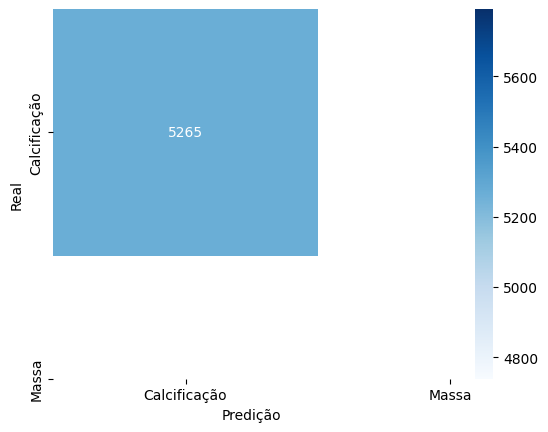

In [26]:
cm = confusion_matrix(all_labels, all_preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Calcificação','Massa'],
            yticklabels=['Calcificação','Massa'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()